In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
from sklearn.model_selection import train_test_split
from torchsummary import summary

from dataset import SpectrogramDataset
from utils import plot_confusion_matrix

In [2]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, classes):
        super(CNNClassifier, self).__init__()
        
        self.classes = classes
        num_classes = len(classes)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(128 * 2 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        
        self.criterion = nn.CrossEntropyLoss()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
        
        self.test_confusion_matrix = np.zeros((num_classes, num_classes))
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        
        x = x.view(-1, 128 * 2 * 6)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('train_acc', accuracy, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('val_acc', accuracy)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('test_acc', accuracy)
        
        confusion_matrix = self.confusion_matrix(predicted, y)
        self.test_confusion_matrix += confusion_matrix.cpu().numpy()
        
    def test_epoch_end(self, outputs):
        plot_confusion_matrix(self.test_confusion_matrix, self.classes, filename='confusion_matrix.png')
        
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x = batch
        y_hat = self(x)
        
        _, predicted = torch.max(y_hat, 1)
        return predicted

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [3]:
spectrograms = np.load('data/training.npy')
labels = np.load('data/training_labels.npy')

print('Spectrogram shape:', spectrograms.shape)
print('Labels shape:', labels.shape)

print('Spectrogram dtype:', spectrograms.dtype)

Spectrogram shape: (52890, 32, 96)
Labels shape: (52890,)
Spectrogram dtype: float32


In [4]:
TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1

if TRAINING_RATIO + VALIDATION_RATIO + TEST_RATIO != 1:
    raise ValueError('Training, validation, and test ratios must sum to 1.')

train_size = int(TRAINING_RATIO * len(spectrograms))
val_size = int(VALIDATION_RATIO * len(spectrograms))
test_size = len(spectrograms) - train_size - val_size

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=val_size, random_state=42)
train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(train_spectrograms, train_labels, test_size=test_size, random_state=42)

print('Training samples:', train_spectrograms.shape[0])
print('Validation samples:', val_spectrograms.shape[0])
print('Test samples:', test_spectrograms.shape[0])

Training samples: 42312
Validation samples: 5289
Test samples: 5289


In [5]:
# Define data transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transforms here
])

In [6]:
BATCH_SIZE = 32
NUM_WORKERS = 4

# Create datasets and dataloaders
train_dataset = SpectrogramDataset(train_spectrograms, train_labels, transform=transform)
val_dataset = SpectrogramDataset(val_spectrograms, val_labels, transform=transforms.ToTensor())
test_dataset = SpectrogramDataset(test_spectrograms, test_labels, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [7]:
CLASSES = ['Other', 'Music', 'Human voice', 'Engine sounds', 'Alarm']

model = CNNClassifier(classes=CLASSES)

summary(model, (1, 32, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 96]             160
              ReLU-2           [-1, 16, 32, 96]               0
         MaxPool2d-3           [-1, 16, 16, 48]               0
            Conv2d-4           [-1, 32, 16, 48]           4,640
              ReLU-5           [-1, 32, 16, 48]               0
         MaxPool2d-6            [-1, 32, 8, 24]               0
            Conv2d-7            [-1, 64, 8, 24]          18,496
              ReLU-8            [-1, 64, 8, 24]               0
         MaxPool2d-9            [-1, 64, 4, 12]               0
           Conv2d-10           [-1, 128, 4, 12]          73,856
             ReLU-11           [-1, 128, 4, 12]               0
        MaxPool2d-12            [-1, 128, 2, 6]               0
           Linear-13                  [-1, 256]         393,472
             ReLU-14                  [

In [8]:
MAX_EPOCHS = 30
VERSION = 'cnn_v2_epoch-30-v2'

accelerator = None
if torch.cuda.is_available():
    accelerator = 'gpu'
elif torch.backends.mps.is_available():
    accelerator = 'cpu'  # MPS is not implemented in PyTorch yet

tb_logger = loggers.TensorBoardLogger('.', version=VERSION)
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, save_last=True, filename='best-{epoch}-{val_acc:.2f}')

trainer = Trainer(accelerator=accelerator, max_epochs=MAX_EPOCHS, logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, train_loader, val_loader)


  | Name             | Type                      | Params
---------------------------------------------------------------
0 | conv1            | Conv2d                    | 160   
1 | conv2            | Conv2d                    | 4.6 K 
2 | conv3            | Conv2d                    | 18.5 K
3 | conv4            | Conv2d                    | 73.9 K
4 | relu             | ReLU                      | 0     
5 | maxpool          | MaxPool2d                 | 0     
6 | fc1              | Linear                    | 393 K 
7 | fc2              | Linear                    | 1.3 K 
8 | criterion        | CrossEntropyLoss          | 0     
9 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.968     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [11]:
# Load previously trained model
CHECKPOINT_PATH = f'lightning_logs/{VERSION}/checkpoints/best-epoch=7-val_acc=0.87.ckpt'

model = CNNClassifier.load_from_checkpoint(CHECKPOINT_PATH, classes=CLASSES)
print(f'Model size: {os.path.getsize(CHECKPOINT_PATH) / 1e6} MB')

Model size: 5.918994 MB


Testing: 0it [00:00, ?it/s]

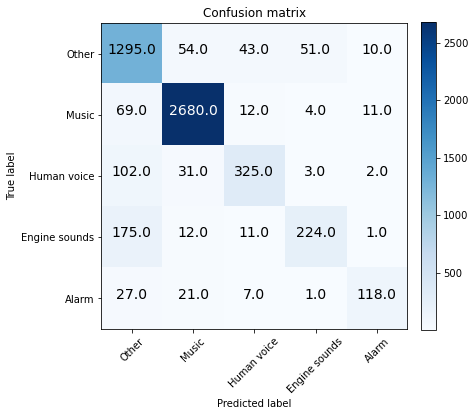

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8776706457138062
        test_loss           0.34933510422706604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.34933510422706604, 'test_acc': 0.8776706457138062}]

In [12]:
trainer.test(model, test_loader) # This not the challenge, test set

In [13]:
spectrograms_to_predict = np.load('data/test.npy')

print('Test spectrogram to predict shape:', spectrograms_to_predict.shape)
print('Test spectrogram to predict dtype:', spectrograms_to_predict.dtype)

Test spectrogram to predict shape: (5347, 32, 96)
Test spectrogram to predict dtype: float32


In [14]:
test_to_predict_dataset = SpectrogramDataset(spectrograms_to_predict, transform=transforms.ToTensor())
test_to_predict_loader = DataLoader(test_to_predict_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [15]:
predictions = trainer.predict(model, test_to_predict_loader)
predictions = np.concatenate(predictions).astype(int)

Predicting: 1323it [00:00, ?it/s]

In [16]:
np.savetxt('predictions.txt', predictions, delimiter='\n', fmt='%d')